# Decision Tree Income Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

Load the UCI Income Data set and make a test-split. We convert categorical data first and drop NA rows.

In [2]:
# Step 1: Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
path = "data/adult.data"
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 
    'hours-per-week', 'native-country', 'income'
]
data = pd.read_csv(path, names=column_names, na_values=" ?", skipinitialspace=True)

# Step 2: Preprocess the data
# Handle missing values by dropping rows with NaN values (you can also fill them if needed)
data.dropna(inplace=True)

# Convert categorical columns to numeric using LabelEncoder
label_encoder = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns

for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Split the dataset into features (X) and target (y)
X = data.drop(columns=['income'])
y = data['income']

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Make a vanilla sklearn DecisionTree model using entropy

In [3]:
# Step 4: Train a Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, criterion='entropy')
model.fit(X_train, y_train)

# Step 5: Make predictions and evaluate the model
y_pred = model.predict(X_test)

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8091


Plot the tree (this will take a while)

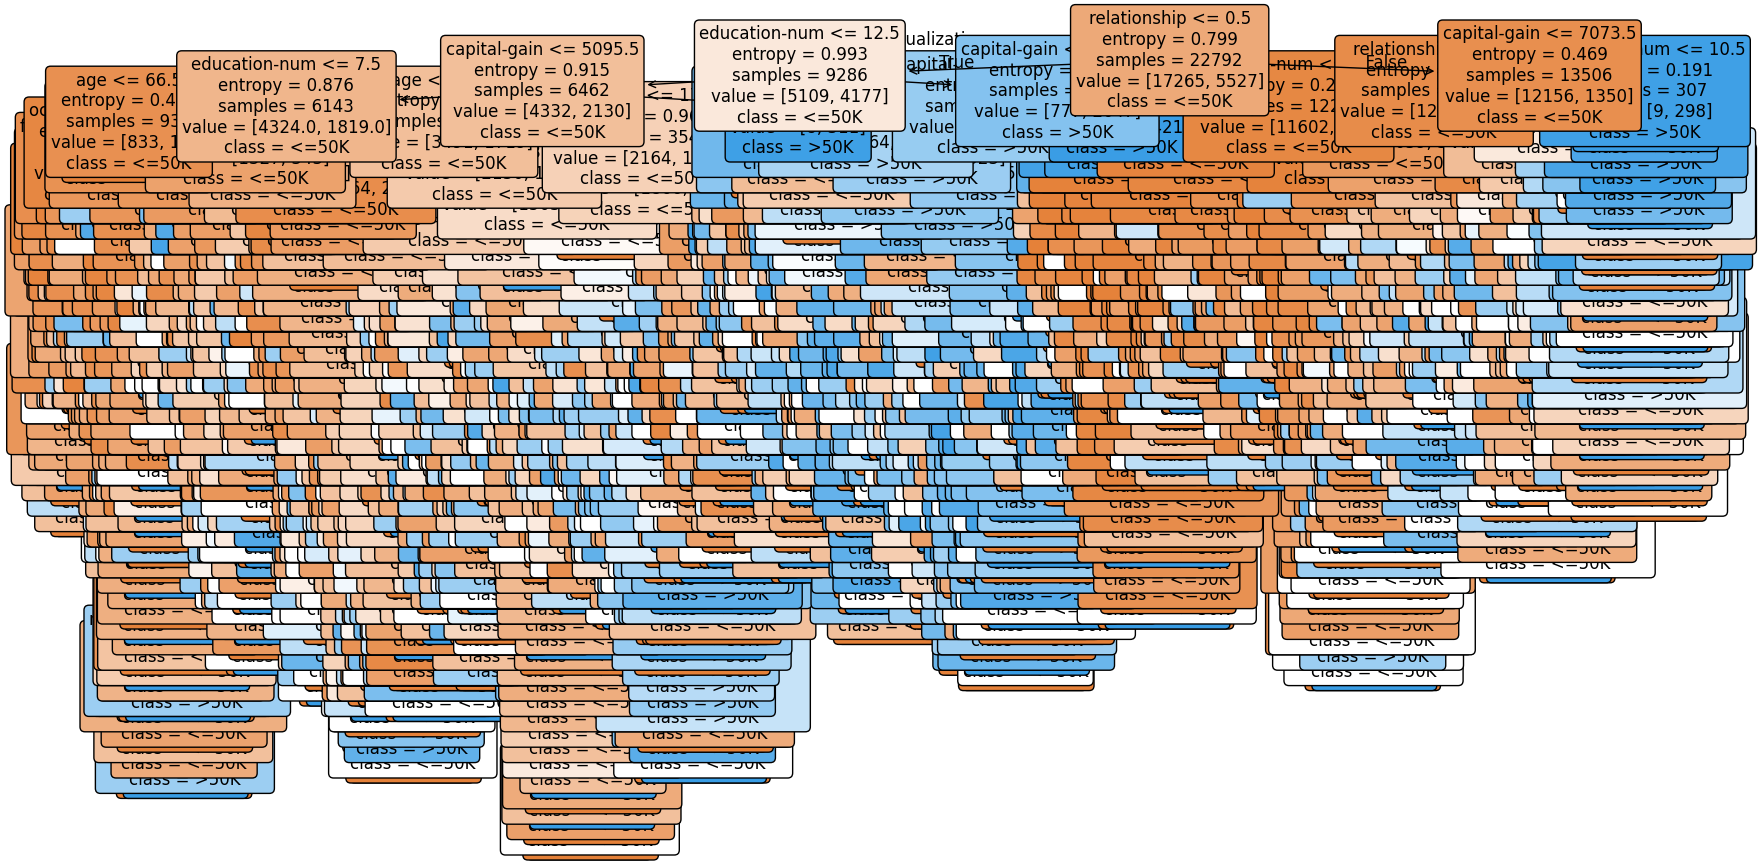

In [4]:
# Step 6: Visualize the Decision Tree
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, class_names=['<=50K', '>50K'], filled=True, rounded=True, fontsize=12)
plt.title("Decision Tree Visualization")
plt.show()

## EDA

Do some standard EDA to learn about this dataset. How many features? How many rows? How many NA entries? How balanced is it? Are there correlations between features or between features and the target? Use previous labs for examples.

In [5]:
data2 = pd.read_csv("data/adult.data", names=column_names, skipinitialspace=True)

In [6]:
print(data2.shape) 
data2.isna().sum()

(32561, 15)


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

It looks like this dataset doesn't have any missing values.

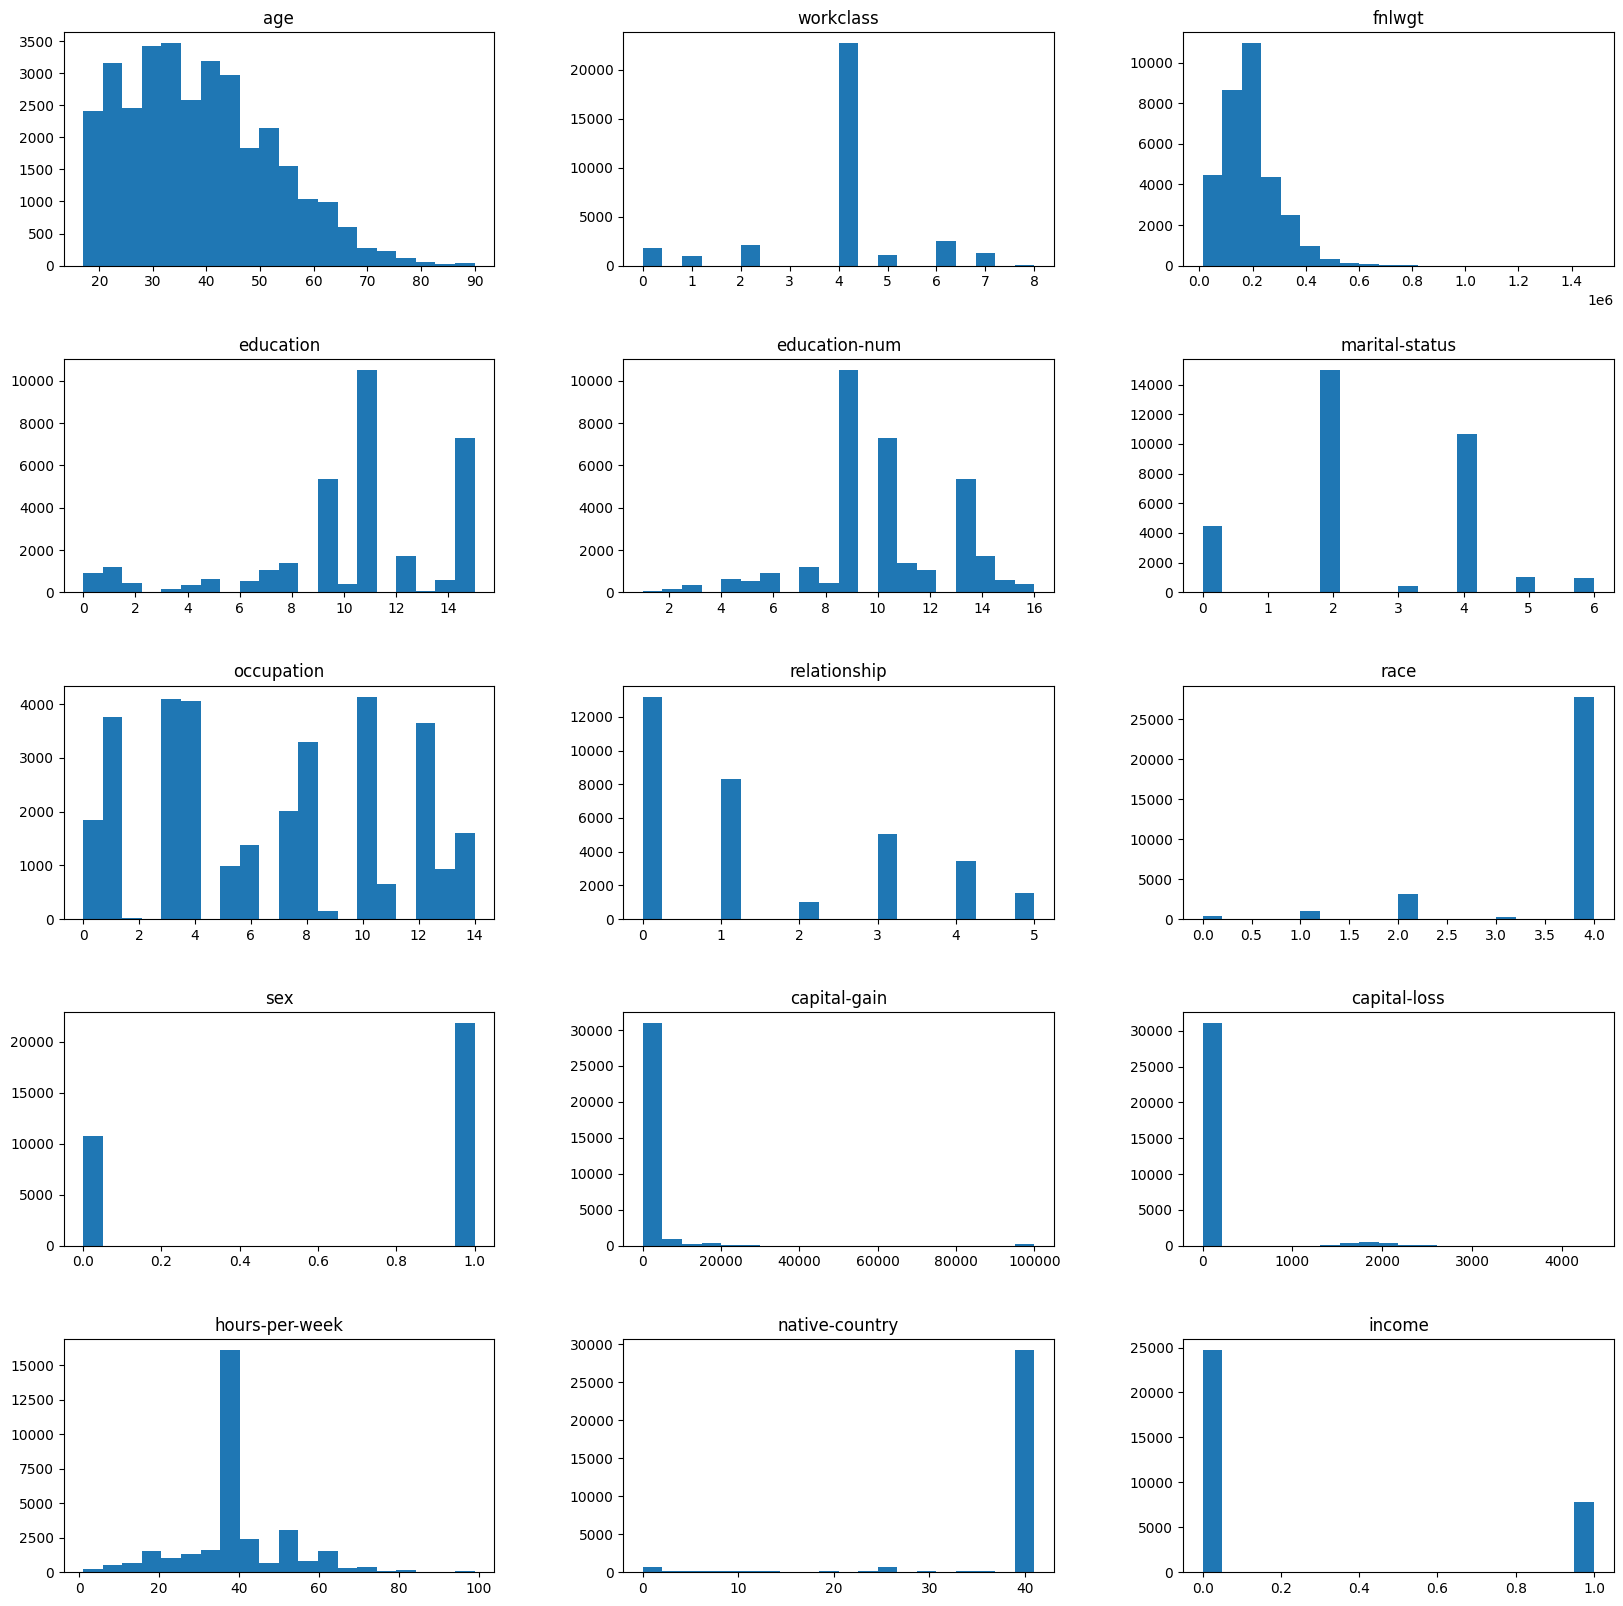

In [7]:
fig, axes = plt.subplots(5, 3, figsize=(20, 20))
for ax, feature in zip(axes.flatten(), data.columns):
    ax.hist(data[feature], bins=20)
    ax.set_title(feature)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

Most of the features seem numerical, but there are categorical ones (like race, relationship, and workclass). Most features are not evenly distributed, and the data seems to be mostly from people living in the US.

## Training Improvement

Try to improve the accuracy of the model, but also explore the parameters available to you. For example

* What happens if you fill in the NA rows rather than drop the?
* What about different ways to fill in the NA rows?
* What is the effect of max_depth on the accuracy?
* Look at other parameters you can adjust in DecisionTreeClassifier and determine their effect

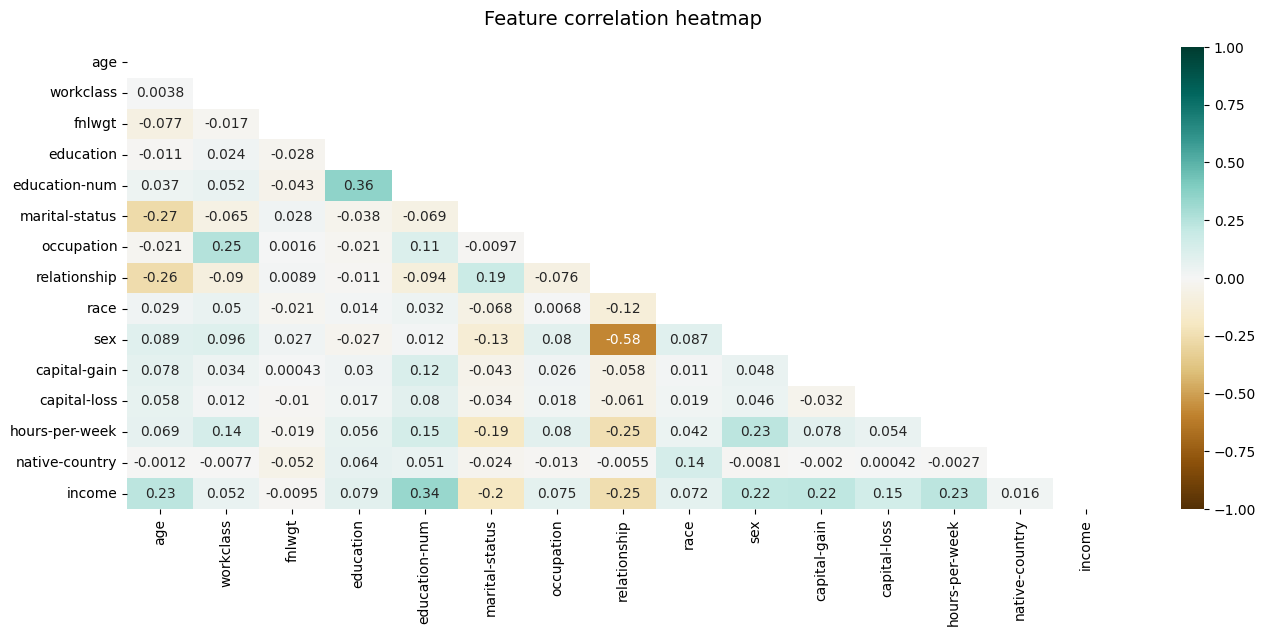

In [8]:
import numpy as np
import seaborn as sns
heat = data.corr()

plt.figure(figsize=(16, 6))
mask = np.triu(np.ones_like(heat, dtype=np.bool))
heatmap = sns.heatmap(heat, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Feature correlation heatmap', fontdict={'fontsize':14}, pad=16);
plt.show()

It looks like relationship and sex are strongly correlated, so i'll try removing relationship.

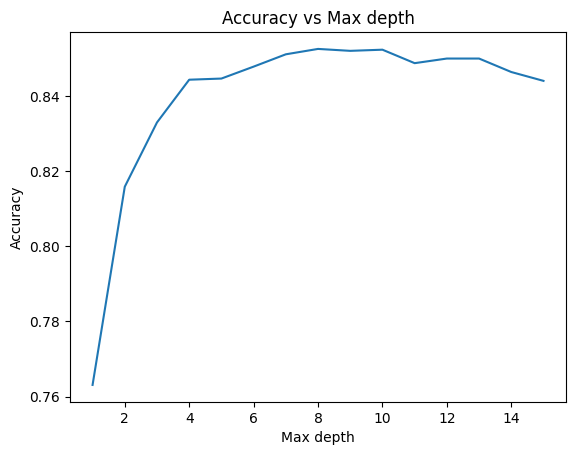

In [9]:
X = data.drop(columns=['income', 'relationship'])
y = data['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

layers = np.unique(np.linspace(1, 15, 15)).astype(int)
accuracy = np.array([])

for layer in layers:
    model = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=layer)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = np.append(accuracy, accuracy_score(y_test, y_pred))

plt.plot(layers, accuracy)
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max depth')
plt.show()

In [10]:
np.max(accuracy), np.argmax(accuracy)

(np.float64(0.852492578564848), np.int64(7))

It looks like the best max depth for the tree is 7. I'll try changing the "criterion" parameter to see how it changes.

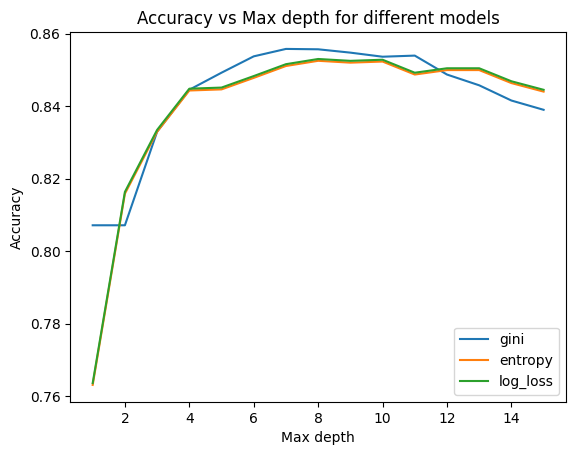

In [23]:
X = data.drop(columns=['income', 'relationship'])
y = data['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

layers = np.unique(np.linspace(1, 15, 15)).astype(int)
accuracy = [[],[],[]]

for layer in layers:
    model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=layer)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy[0].append(accuracy_score(y_test, y_pred))
    model = DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=layer)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy[1].append(accuracy_score(y_test, y_pred))
    model = DecisionTreeClassifier(random_state=42, criterion='log_loss', max_depth=layer)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy[2].append(accuracy_score(y_test, y_pred))


plt.plot(layers, accuracy[0], label='gini')
plt.plot(layers, accuracy[1], label='entropy')
plt.plot(layers, np.array(accuracy[2]) + 0.0005, label='log_loss')
plt.legend()
plt.xlabel('Max depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max depth for different models')
plt.show()

Testing the different classification criteria, it looks like gini is the best one. Both entropy and log_loss perform the exact same, so I shifted log_loss up a bit to make it more visible. Maybe there are other parameters to try. I'll test the splitter and the min_samples_split. Looking at the documentation, min_samples_split is the fraction of the dataset required to split one group into two branches.

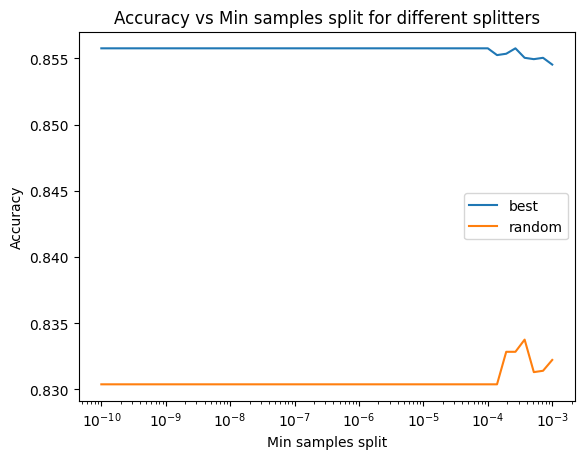

Best accuracy: 0.8557682464940116 
Best min_samples_split: 1e-10


In [36]:
accuracy = [[],[]]
alphas = np.logspace(-10, -3, 50, base=10)

for alpha in alphas:
    model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=7, min_samples_split=alpha, splitter='best')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy[0].append(accuracy_score(y_test, y_pred))
    model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=7, min_samples_split=alpha, splitter='random')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy[1].append(accuracy_score(y_test, y_pred))
    
plt.plot(alphas, accuracy[0], label='best')
plt.plot(alphas, accuracy[1], label='random')
plt.xscale('log')
plt.legend()
plt.xlabel('Min samples split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Min samples split for different splitters')
plt.show()

print("Best accuracy:", np.max(accuracy[0]), "\nBest min_samples_split:", alphas[np.argmax(accuracy[0])])

The "best" splitter clearly outperforms the "random" splitter on every case, only matching when the alpha is very close to 1. The min_samples_split looks like it doesn't do much, and the best value for it seems to be the lowest one possible. I'll probably just leave this out of the final model. Next, i'll try min_samples_leaf, which dictates how many samples are required to be in one leaf node for it to be created. I think both of these parameters are to stop overfitting, which is probably what happened with the massive tree from the beginning.

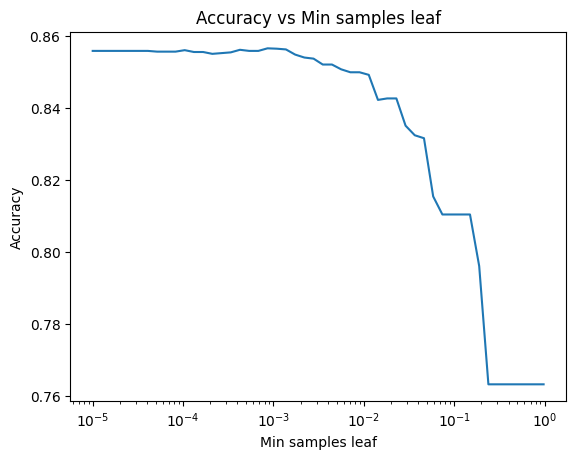

Best accuracy: 0.8564847988535162 
Best min_samples_leaf: 0.0008607914788688796


In [39]:
accuracy = []
alphas = np.logspace(-5, -0.01, 50, base=10)

for alpha in alphas:
    model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=7, min_samples_leaf=alpha, splitter='best')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

plt.plot(alphas, accuracy)
plt.xscale('log')
plt.xlabel('Min samples leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Min samples leaf')
plt.show()

print("Best accuracy:", np.max(accuracy), "\nBest min_samples_leaf:", alphas[np.argmax(accuracy)])

It looks like 0.086% is the best fraction of the dataset in each leaf node. The accuracy doesn't seem to change much, only around 0.1%. The only other parameter that seems worth looking into is the max number of leaf nodes.

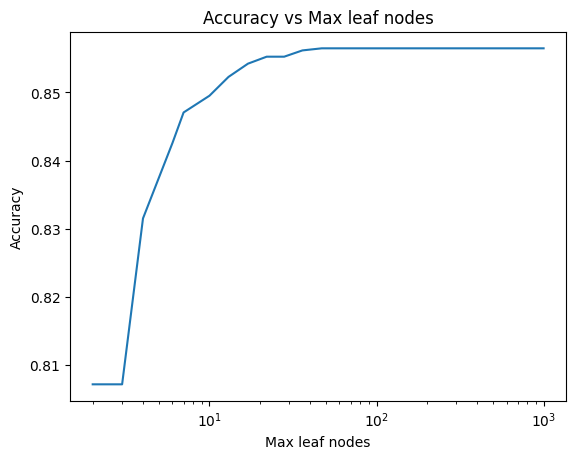

Best accuracy: 0.8564847988535162 
Best max_leaf_nodes: 47


In [49]:
leafs = np.unique(np.logspace(0.35, 3, 25, base=10).astype(int))
accuracy = []

for leaf in leafs:
    model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=7, min_samples_leaf=0.000861, max_leaf_nodes=leaf, splitter='best')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))

plt.xscale('log')
plt.plot(leafs, accuracy)
plt.xlabel('Max leaf nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max leaf nodes')
plt.show()

print("Best accuracy:", np.max(accuracy), "\nBest max_leaf_nodes:", leafs[np.argmax(accuracy)])

It seems like after a certain number of leaves are reached, the model stops getting any better. The ideal number of leaf nodes seems to be around 50. The accuracy is still the same, around 85.6%.

## Conclusion

The best parameters for the final max depth are a max depth of 7, at least 0.086% of the dataset in each leaf node, a max of 50 leaf nodes, a splitter of "best", and a criterion of "gini".

In [51]:
model = DecisionTreeClassifier(random_state=42, criterion='gini', max_depth=7, min_samples_leaf=0.000861, max_leaf_nodes=50, splitter='best')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Final accuracy:", accuracy_score(y_test, y_pred))

Final accuracy: 0.8564847988535162


The final improvement was $0.8564- 0.8091 = 0.0473%$. It's a decent increase, and most of it came from limiting the number of layers to stop overfitting of the training set. Here's the final model:

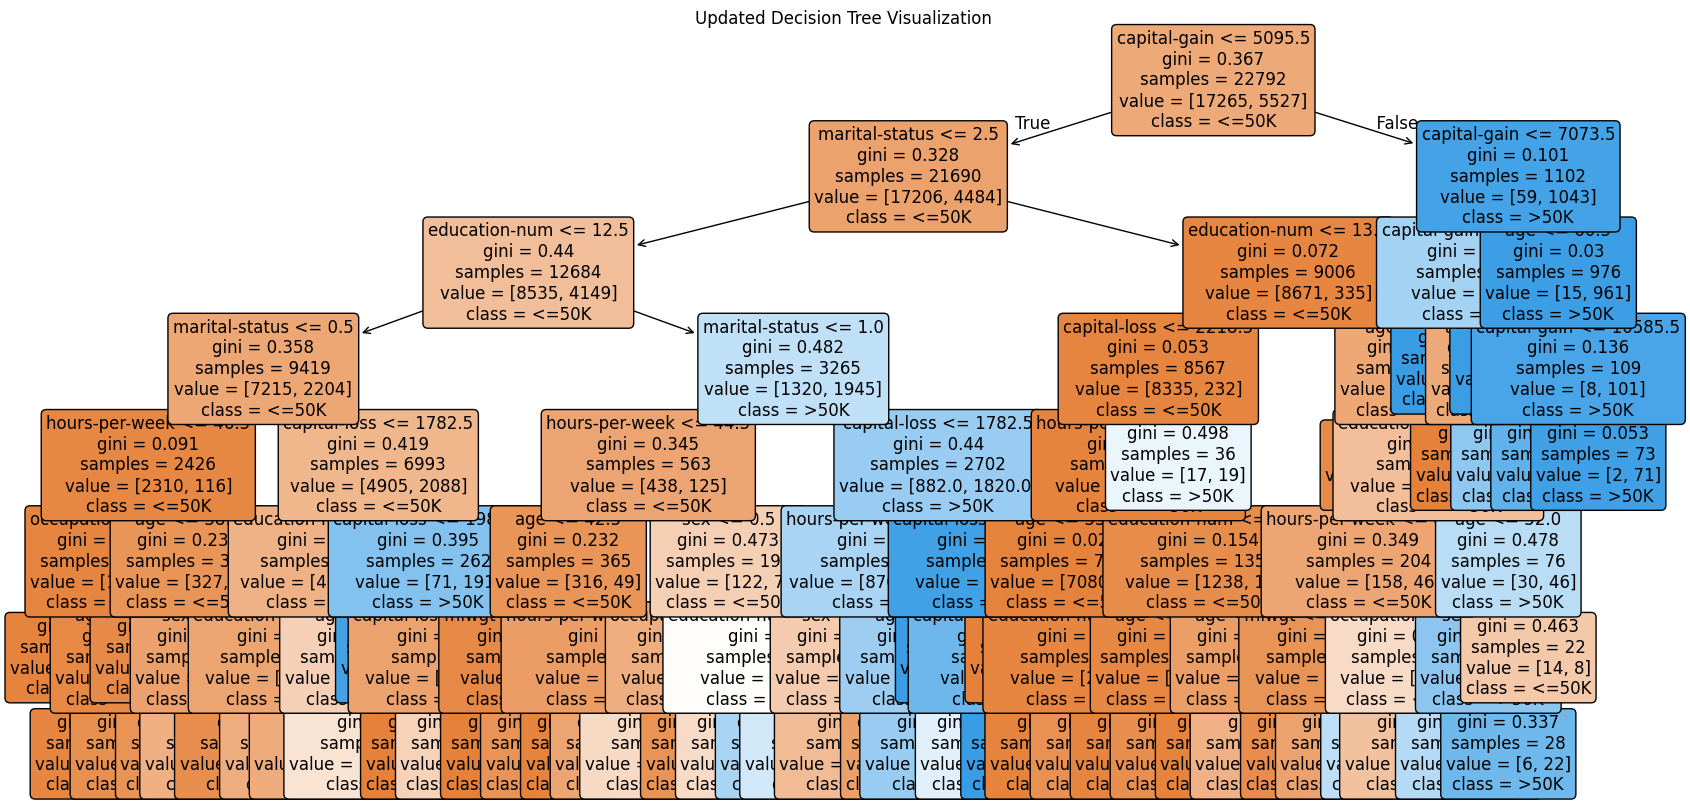

In [53]:
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=X.columns, class_names=['<=50K', '>50K'], filled=True, rounded=True, fontsize=12)
plt.title("Updated Decision Tree Visualization")
plt.show()

The tree is much smaller because of the layer and node limitations, and it takes way less time to plot. It's also possible to see what's going on a little bit, compared to the other plot having each node just barely on screen. 